In [1]:
# @Author: Ivan
# @LastEdit: 2020/8/13
import os
import time
import numpy as np  # install
import keras  # install
from keras.regularizers import l1, l2
from keras import backend as K
from keras.utils import np_utils
#from keras.utils import plot_model
#from keras.optimizers import SGD
from tensorflow.keras.optimizers import SGD
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers import Dense, Dropout, Activation, Flatten
import matplotlib.pyplot as plt  # install

# from image_util import show_intermediate_output, show_heatmap

np.random.seed(1337)
# os.environ["PATH"] += os.pathsep + \
#                       'C:/Program Files (x86)/Graphviz2.38/bin'

epochs = 50
nb_classes = 5
nb_per_class = 10000
batch_size = 32
learning_rate = 0.0001
activation = 'relu'
width, height, depth = 278, 158, 1
nb_filters1, nb_filters2 = 5, 10
train_proportion = 0.8
valid_proportion = 0.1
test_proportion = 0.1

In [2]:
def set_model(lr=learning_rate, decay=1e-6, momentum=0.9):
    model = Sequential()
    if K.image_data_format() == 'channels_first':
        model.add(SeparableConv2D(nb_filters1, kernel_size=(3, 3), kernel_regularizer=l2(0.01),
                                  input_shape=(depth, height, width), name='conv1'))
    else:
        model.add(SeparableConv2D(nb_filters1, kernel_size=(3, 3),
                                  input_shape=(height, width, depth), name='conv1'))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), name='maxpooling1'))
    model.add(Dropout(0.5))

    model.add(SeparableConv2D(nb_filters2, kernel_size=(3, 3),
                              kernel_regularizer=l2(0.01), name='conv2'))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), name='maxpooling2'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128, kernel_regularizer=l2(
        0.01), name='dense1'))  # Full connection
    model.add(Activation(activation))
    model.add(Dropout(0.5))

    model.add(Dense(nb_classes, name='dense2'))  # output
    model.add(Activation('softmax'))

    sgd = SGD(lr=learning_rate, decay=decay, momentum=momentum,
              nesterov=True)  # optimizer
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd, metrics=['accuracy'])
    model.summary()  # 输出模型各层的参数状况
    return model


In [3]:
class LossHistory(keras.callbacks.Callback):
    # 损失历史记录 输出参数变化图像
    def on_train_begin(self, logs={}):
        self.losses = {'batch': [], 'epoch': []}
        self.accuracy = {'batch': [], 'epoch': []}
        self.val_loss = {'batch': [], 'epoch': []}
        self.val_acc = {'batch': [], 'epoch': []}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))  # train loss
        self.accuracy['epoch'].append(logs.get('acc'))  # train acc
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure(num='Change of parameters')
        # train acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # train loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')

        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')

        plt.title('epoch=' + str(epochs) + ',lr=' + str(learning_rate) + ',batch_size=' + str(batch_size)
                  + '\nactivation=' + activation + ',nb_classes=' + str(nb_classes) + ',nb_per_class=' + str(
            nb_per_class))
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        now = time.strftime('%Y-%m-%d@%H-%M-%S', time.localtime(time.time()))
        plt.savefig('./parameter/' + now + '.jpg')
        plt.show()


history = LossHistory()

In [4]:
def train_model(model, X_train, Y_train, X_val, Y_val):
    # tensorboard = keras.callbacks.TensorBoard(
    #     log_dir='F:/Log/', histogram_freq=1)

    model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, shuffle=True,
              verbose=1, validation_data=(X_val, Y_val), callbacks=[history])
    model.save('model.h5')
    return model


def test_model(X_test, Y_test):
    model = load_model('model.h5')
    score = model.evaluate(X_test, Y_test, verbose=0)
    return score

X_train shape: (8000, 158, 278, 1)
Class number: 5
8000 train samples
1000 validate samples
1000 test samples
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (SeparableConv2D)      (None, 156, 276, 5)       19        
_________________________________________________________________
activation_4 (Activation)    (None, 156, 276, 5)       0         
_________________________________________________________________
maxpooling1 (MaxPooling2D)   (None, 78, 138, 5)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 78, 138, 5)        0         
_________________________________________________________________
conv2 (SeparableConv2D)      (None, 76, 136, 10)       105       
_________________________________________________________________
activation_5 (Activation)    (None, 76, 136, 10)       0         
__________

D:\conda\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/50
250/250 [==============================] - 41s 158ms/step - loss: 3.5318 - accuracy: 0.7042 - val_loss: 3.3848 - val_accuracy: 0.7960
Epoch 2/50
250/250 [==============================] - 41s 166ms/step - loss: 3.3252 - accuracy: 0.7582 - val_loss: 3.3705 - val_accuracy: 0.7960
Epoch 3/50
250/250 [==============================] - 41s 164ms/step - loss: 3.2624 - accuracy: 0.7585 - val_loss: 3.3493 - val_accuracy: 0.7960
Epoch 4/50
250/250 [==============================] - 41s 165ms/step - loss: 3.1971 - accuracy: 0.7599 - val_loss: 3.2967 - val_accuracy: 0.7960
Epoch 5/50
250/250 [==============================] - 41s 164ms/step - loss: 3.1336 - accuracy: 0.7601 - val_loss: 3.2601 - val_accuracy: 0.7960
Epoch 6/50
250/250 [==============================] - 41s 164ms/step - loss: 3.0641 - accuracy: 0.7703 - val_loss: 3.2188 - val_accuracy: 0.7960
Epoch 7/50
250/250 [==============================] - 41s 164ms/step - loss: 2.9915 - accuracy: 0.7845 - val_loss: 3.1847 - val_ac

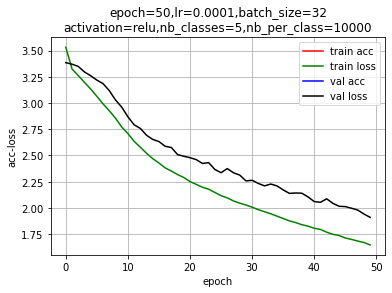

In [6]:
def load_data():
    #train_data = np.load('train_data.npy',allow_pickle=True)[:nb_per_class]
    train_data = np.load('train_data.npy',allow_pickle=True)[:nb_per_class]
    train_img = train_data[:, 0]
    train_label = train_data[:, 1]

    images = []
    for img in train_img:
        img_ndarray = np.asarray(img, dtype='float64') / 255
        data = np.ndarray.flatten(img_ndarray)
        data = data.astype('float32')
        images.append(data)
    images = np.asarray(images)

    labels = []
    for label in train_label:
        if label == [1, 0, 0, 0, 0]:
            labels.append(0)
        elif label == [0, 1, 0, 0, 0]:
            labels.append(1)
        elif label == [0, 0, 1, 0, 0]:
            labels.append(2)
        elif label == [0, 0, 0, 1, 0]:
            labels.append(3)
        elif label == [0, 0, 0, 0, 0]:
            labels.append(4)
            
    labels = np.asarray(labels)

    train_per_category = int(nb_per_class * train_proportion)
    valid_per_category = int(nb_per_class * valid_proportion)

    X_train = images[:train_per_category]
    X_val = images[train_per_category:train_per_category + valid_per_category]
    X_test = images[train_per_category + valid_per_category:]

    y_train = labels[:train_per_category]
    y_val = labels[train_per_category:train_per_category + valid_per_category]
    y_test = labels[train_per_category + valid_per_category:]
    rval = [(X_train, y_train), (X_val, y_val), (X_test, y_test)]
    return rval


def main():
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = load_data()
    if K.image_data_format() == 'channels_first':
        X_train = X_train.reshape(X_train.shape[0], depth, height, width)
        X_val = X_val.reshape(X_val.shape[0], depth, height, width)
        X_test = X_test.reshape(X_test.shape[0], depth, height, width)
    else:
        X_train = X_train.reshape(X_train.shape[0], height, width, depth)
        X_val = X_val.reshape(X_val.shape[0], height, width, depth)
        X_test = X_test.reshape(X_test.shape[0], height, width, depth)

    print('X_train shape:', X_train.shape)
    print('Class number:', nb_classes)
    print(X_train.shape[0], 'train samples')
    print(X_val.shape[0], 'validate samples')
    print(X_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    Y_train = np_utils.to_categorical(y_train, nb_classes)
    Y_val = np_utils.to_categorical(y_val, nb_classes)
    Y_test = np_utils.to_categorical(y_test, nb_classes)

    model = set_model()

    # plot_model(model, to_file='model.png', show_shapes=True)

    start = time.perf_counter()
    model = train_model(model, X_train, Y_train, X_val, Y_val)
    end = time.perf_counter()

    #pred_classes = model.predict_classes(X_test, verbose=0)
    pred_classes = model.predict(X_test) 
    pred_classes = np.argmax(pred_classes,axis=1)

    test_accuracy = np.mean(np.equal(y_test, pred_classes))
    right = np.sum(np.equal(y_test, pred_classes))

    print('Total training time:', end - start)
    print('Test number:', len(Y_test))
    print('Test right:', right)
    print('Test wrong:', len(Y_test) - right)
    print('Test accuracy:', test_accuracy)

    history.loss_plot('epoch')


if __name__ == '__main__':
    main()
